In [118]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import functions.token_functions as tf
import spacy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
import string
from langdetect import detect
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from collections import Counter
from wordcloud import WordCloud 

In [19]:
nlp = spacy.load('en_core_web_sm')
sw = stopwords.words("english")

In [52]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/games',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/games/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
games_df = pd.concat(df_list, ignore_index=True)


In [53]:
games_df.head()

,name,game_title,review_title,review,rating,date_place
0,Jesus Díaz,Just Dance 2022 (Xbox One/Series X),JUEGO ORIGINAL,El juego viene sellado de fábrica. ¡Muy buena ...,5.0,"Reviewed in the United States 🇺🇸 on June 1, 2023"
1,Bill P Englert,Just Dance 2022 (Xbox One/Series X),Love this for the family,Really enjoy Just Dance especially when doing ...,4.0,Reviewed in the United States 🇺🇸 on December 1...
2,s,Just Dance 2022 (Xbox One/Series X),Fun game,Nothing wrong with purchase but game itself do...,5.0,Reviewed in the United States 🇺🇸 on November 2...
3,KrysnJonRodriguez,Just Dance 2022 (Xbox One/Series X),Amazing graphics!,"I’ve used Just Dance on WII previously, but th...",5.0,Reviewed in the United States 🇺🇸 on January 20...
4,Cody Jaylene Mosley,Just Dance 2022 (Xbox One/Series X),Super fun,Whole family loves it!,5.0,Reviewed in the United States 🇺🇸 on January 15...


In [54]:
# drop values
games_df = games_df.dropna()

# drop non english reviews
# games_df['lang'] = games_df['review'].apply(tf.detect_language)
# games_df = games_df.query('lang == "en"')
def detect_language(text):
    if text.strip() == '':
        return 'unknown'
    try:
        return detect(text)
    except:
        return 'unknown'
games_df['lang'] = games_df['review'].apply(detect_language)

games_df = games_df.query('lang == "en"')


In [114]:
# games_df['review_tokens'] = games_df['review'].apply(tf.clean_tokenize)
# games_df['review_title_tokens'] = games_df['review_title'].apply(tf.clean_tokenize)

punctuation = set(string.punctuation)
negation_words = ["not", "no", "never", "none", "nobody", "nothing", "nowhere"]
sw = set(stopwords.words('english')) - set(negation_words)
# Function to clean and tokenize the lyrics
def clean_tokenize(text):
    if text is None:
        return []
    # Remove punctuation
    clean_text = ''.join([c for c in text if c not in punctuation])
    # Convert tokens to lowercase
    clean_text = clean_text.lower()
    # Tokenize the text
    tokens = text.split()
    # Remove stopwords
    stop_words = sw
    tokens = [token for token in tokens if token not in sw]
    #Join tokens into a single string
    string_tokens = ' '.join(tokens)
    #return string_tokens
    return tokens
games_df['review_tokens'] = games_df['review'].apply(clean_tokenize)
games_df['review_title_tokens'] = games_df['review_title'].apply(clean_tokenize)

In [115]:
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print the number of tokens, number of unique tokens,
    number of characters, lexical diversity, and num_tokens most common tokens.
    Return a list of the num_tokens most common tokens.
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / num_tokens

    if verbose:
        print("Number of tokens:", num_tokens)
        print("Number of unique tokens:", num_unique_tokens)
        print("Number of characters:", num_characters)
        print("Lexical diversity:", lexical_diversity)
        # Print the 5 most common tokens
        common_tokens = Counter(tokens).most_common(num_tokens)
        print("The most common tokens are:")
        for token, count in common_tokens[:5]: #print out 5 most common token
            print(f"{token}: {count}")

# calls descriptive_stats 
descriptive_stats(games_df['review_tokens'].explode())

Number of tokens: 50339
Number of unique tokens: 11741
Number of characters: 271816
Lexical diversity: 0.23323864200719124
The most common tokens are:
I: 1540
game: 1372
The: 539
not: 514
like: 350


In [112]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

#     wc = WordCloud(width=800, height=400, 
#                    background_color= "black", colormap="Paired", 
#                    max_font_size=150, max_words=max_words)
    #font_path = os.path.abspath('/Users/lamnguyen/Library/Group Containers/\
    #UBF8T346G9.Office/FontCache/4/CloudFonts/Libre Franklin/18949476423.ttf')
  
    wc = WordCloud(width=800, height=400, background_color="black", 
                   colormap="Paired", max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

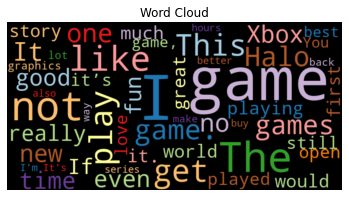

In [116]:
#rtokens_lst = combined_data['rtokens'].explode().tolist()
word_freq = count_words(games_df, column='review_tokens', min_freq=2)
wordcloud(word_freq['freq'], title='Word Cloud', max_words=50)
plt.show()

In [86]:
games_df.groupby(['rating'])['review'].count()

rating
1.0    355
2.0     68
3.0     81
4.0    106
5.0    677
Name: review, dtype: int64

In [57]:
games_df['sentiment'] = 0
games_df.loc[games_df['rating']>3, 'sentiment'] = 1
games_df.loc[games_df['rating']<=3, 'sentiment'] = 0

<AxesSubplot:xlabel='sentiment', ylabel='count'>

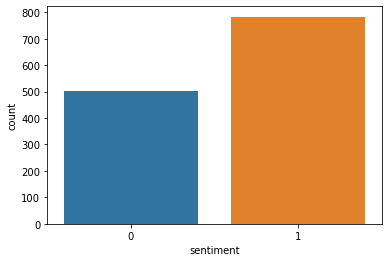

In [58]:
sns.countplot(x=games_df['sentiment'])

## Split Data

In [119]:
#high_low_df = games_df.query('rating == 1 | rating ==5')
#high_low_df.shape

In [120]:
#X = high_low_df[['review_tokens', 'review_title_tokens']]
#y = high_low_df['rating']

In [96]:
stopwords_list = list(sw)

# Data Preparation
games_df['review'] = games_df['review'].apply(clean)

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(games_df['review'],
                                                    games_df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=10,
                                                    stratify= games_df['sentiment'])

In [97]:
#tf.sentiment_stats(X_train, X_test, y_train, y_test)
def sentiment_stats(x_train,x_test, y_train, y_test):
    print ('Size of Training Data ', x_train.shape[0])
    print ('Size of Test Data ', x_test.shape[0])
    print ('Distribution of classes in Training Data :')
    print ('Positive Sentiment ', str(sum(y_train == 1)/ len(y_train) * 100.0))
    print ('Negative Sentiment ', str(sum(y_train == 0)/ len(y_train) * 100.0))
    print ('Distribution of classes in Testing Data :')
    print ('Positive Sentiment ', str(sum(y_test == 1)/ len(y_test) * 100.0))
    print ('Negative Sentiment ', str(sum(y_test == 0)/ len(y_test) * 100.0))
sentiment_stats(X_train, X_test, y_train, y_test)

Size of Training Data  1029
Size of Test Data  258
Distribution of classes in Training Data :
Positive Sentiment  60.89494163424124
Negative Sentiment  39.10505836575876
Distribution of classes in Testing Data :
Positive Sentiment  60.85271317829457
Negative Sentiment  39.14728682170542


In [61]:
def clean(text):
    # convert html escapes like &amp; to characters.
    #text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [78]:

# Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words=stopwords_list)


model = SVC(random_state=42, probability=True)
grid_param = {'tfidf__min_df': [5, 10],
              'tfidf__ngram_range': [(1, 3), (1, 6)], 
              'model__C': [1, 100], 
              'model__kernel': ['linear']
             }

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stopwords_list)), ('model', model)])

gridSearchProcessor = GridSearchCV(estimator=training_pipeline, 
                                   param_grid=grid_param, 
                                   cv=5)

gridSearchProcessor.fit(X_train, Y_train)

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Model Evaluation

Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  1029
Size of Test Data  258
Best alpha parameter identified by grid search  {'model__C': 1, 'model__kernel': 'linear', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.8153729576130713
Accuracy Score -  0.8410852713178295
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       101
           1       0.83      0.92      0.88       157

    accuracy                           0.84       258
   macro avg       0.85      0.82      0.83       258
weighted avg       0.84      0.84      0.84       258



In [84]:
#compare result of prediction on test set to actual value
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred } 
result = pd.DataFrame(frame)
result.head(20)

,text,actual,predicted
546,"Played on Xbox One X, and it runs perfectly. T...",1,1
445,George R. R. Martin and Miyazaki produced a ga...,1,1
1291,10/10 this game is absolutely amazing 👏 well d...,1,1
606,i didnt even get a digital code with my xbox.,0,0
864,"Couldn't ask for any better, thank you",1,1
1048,"A Great game for single player mode, despite l...",1,1
1347,"I really enjoyed 343s latest Halo game, it fel...",1,1
930,Love this game and so happy Microsoft made it ...,1,1
167,You have to use your phone to play. Our young ...,0,0
320,What the crap? I boy the $80 digital deluxe ad...,0,0


## Baseline

In [81]:
clf = DummyClassifier(strategy='most_frequent', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.6085271317829457


## Pickle Models

In [128]:
# with open('../models/svc_model.pkl', 'wb') as file:
#     pickle.dump(svc_model, file)

# with open('../models/tfidf.pkl', 'wb') as file:
#     pickle.dump(tfidf, file)